# FEM Notebook 3: Implementing the Finite Element Method in Python with FEniCSx

## Introduction

Welcome to the third notebook in my series "Understanding and Using the Finite Element Method". Over the course of the last 2 notebooks we have covered much of the 'understanding' part; the mathematical theory for the method. Now it is time for implementation. We will use a specialised computing platform called FEniCSx. I say 'computing platform' and not 'library', because FEniCSx is a collection of libraries that can work together to construct and solve FEM problems.

### Learning Objectives

- To gain an overview of the different components of FEniCSx.
- To be able to construct and solve time-independent PDEs (BVPs) in FEniCSx, including generating meshes, defining mathematical objects and solving, as well as being able to make the right choices for each parameter.
- To be able to visualise the solutions obtained in various ways, through colour plots, 3d plots and 2d "slices".
- To be able to construct finite difference approximations for time-dependent PDEs (IVBPs), solve them, and visualise the solution with an animation.

## 6. Introduction to FEniCSx

### 6.1 What is FEniCSx?

As mentioned before, FEniCSx is an open source computation platform used to construct and solve PDEs using the Finite Element Method. FEniCSx has four main components, although if you decide to look at the Docker image we are hosting Jupyter on, you will see there are many more dependencies needed to actually run it. This, in fact, is why we use a Docker image instead of manually installing all python packages. Many of them cannot be installed via the Package Installer for Python (pip) and require some amount of effort to install. The Docker image is incredibly convenient, the one we use here was created by Jorgen S. Dokken for his FEniCSx tutorial series. The four main components of FEniCSx are:

- **DOLFINx** - This is the main computational backend of FEniCSx. It is the backbone that connects all of the other libraries together and contains the majority of classes and functions. It contains interfaces for input/output, mesh generation, linear equation solvers, manipulation of finite function spaces, and much [more](https://docs.fenicsproject.org/dolfinx/main/python/api.html).
- **UFL** - Unified Form Language is the language used to express variational forms of PDEs. It's syntax is designed to be as close to writing the actual mathematics as possible. You can find the documentation [here](https://docs.fenicsproject.org/ufl/2022.2.0/).
- **FFCx** - The FEniCSx Form Compiler takes a variational form in UFL and compiles it into a linear system of equations, i.e. the mass matrix and load vector. Documentation for this can be found [here](https://github.com/FEniCS/ffcx).
- **Basix** - This deals with the finite elements themselves. It can generate the basis functions of some space and their derivatives, as well as perform interpolation, projection and [more](https://docs.fenicsproject.org/basix/v0.2.0/python/).

### 6.2 Solving the Poisson Equation

Consider the problem,

$$
\begin{align}
-\nabla^2 &u(x,y) = f = 5y^{-\frac32} - 1 \quad &\text{in } \Omega \\
 &u(x,y) = u_D = 20y^\frac12 + \frac12 x^2 + 2x \quad &\text{on } \delta\Omega, \tag*{[9]}
\end{align}
$$

where $\Omega = [0, 1] \times [0, 1]$ i.e. the unit square. This is a standard Poisson equation, that can be solved analytically. We will compare our solution with the analytical solution and try to gauge the error. The first step in solving any problem with FEM is to define a mesh over our domain.

For complicated domains we can use Gmsh to generate a mesh, as seen in the code snippet generating a mesh over the unit disk in section 4.1. However, DOLFINx has its own mesh generator for simple domains, like the unit square. The first argument specifies the MPI communicator used for parallel computation. `MPI.COMM_WORLD` specifies we should distribute over all available processors. The next two arguments are the number of finite elements we wish to have in the $x$ and $y$ directions respectively. Feel free to change these values and see the difference in the result. The final argument is the finite element (also called, cell) type, in this case we choose triangles.

In [1]:
from mpi4py import MPI
from dolfinx import mesh
n = 50
domain = mesh.create_unit_square(MPI.COMM_WORLD, n, n, mesh.CellType.triangle)

Below are a few lines that visualise this mesh using PyVista a 3D mesh visualiser that works very well in Jupyter Notebook. We use DOLFINx to convert our mesh to a VTK mesh. Then we can use Pyvista to convert the VTK mesh into a pyvista unstructured grid, which we can easily plot using the `pythreejs` backend.

In [2]:
import pyvista
from dolfinx import plot
pyvista.start_xvfb()
topology, cell_types, geometry = plot.create_vtk_mesh(domain, domain.topology.dim) # Convert to VTK mesh
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry) # Convert VTK mesh to Unstructured Grid

# Plot
pyvista.set_jupyter_backend('pythreejs')
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

2023-04-22 18:10:28.657 (   3.854s) [        1B54C000]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2023-04-22 18:10:28.665 (   3.863s) [        1B54C000]    vtkExtractEdges.cxx:551   INFO| Created 7600 edges


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

The next step is to define our finite element function space. This is $V_h$.

In [3]:
from dolfinx.fem import FunctionSpace
Vh = FunctionSpace(domain, ("Lagrange", 1))

*Lagrange* here specifies the space we have been dealing with so far, that is the space of continuous piecewise polynomial functions and $1$ specifies this should be the space of linear polynomials. Next we define the boundary conditions. Since our boundary condition, $u(x,y) = 20 y^\frac12 + \frac12 x^2 + 2x$ does not belong to our finite element function space, we need to approximate it in some way. Note, we did not need to do this for our other Poisson example, because the boundary condition was simply a constant. As mentioned in section 5.2, we can do this either by interpolation or $L^2$-projection. The easiest to perform in DOLFINx is interpolation.

In [4]:
from dolfinx import fem
import numpy as np
uD = fem.Function(Vh)

tol = 1e-3

def boundaryCondition(x):
    return 20*np.sqrt(x[1] + tol) + 0.5*x[0]**2 + 2*x[0]

uD.interpolate(boundaryCondition)

When the vertices of our mesh are computed, there is a small degree of error introduced. This means nodes close to $0$ could actually turn out to be negative numbers. Our equation includes a square root, which leads to an imaginary component being added to our interpolated boundary condition. Complex numbers can be configured to work in DOLFINx, and one approach to solving this problem would be to allow this, then only take the real component of the solution. We won't be using this for our purposes, instead we introduce a small tolerance to ensure that we are never taking the square root of a negative number.

We now apply this interpolated function $u_D$ to the degrees of freedom that lie on the boundary of our mesh. This is done through the function `fem.locate_dofs_topological()` which takes a set of facets (line segments connecting nodes of finite elements) and returns the degrees of freedom in that set. First we have to locate these facets, which is done via `mesh.exterior_facet_indices()`. Then, we find the boundary degrees of freedom, and apply the our Dirichlet boundary condition to them.

In [5]:
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

boundary_dofs = fem.locate_dofs_topological(Vh, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

The next step is to actually define the variational problem. To do this we use Unifield Form Language (UFL). Firstly we should define our test and trial spaces. Typically, the boundary conditions would be specified in the definitions of these spaces, but when using FEniCSx, the test and trial spaces are actually the same and the boundary conditions are applied later. As such, we only need to define a pair of test and trial functions from the same space $V_h$.

In [6]:
import ufl
u = ufl.TrialFunction(Vh)
v = ufl.TestFunction(Vh)

Next we define the source term $f$, similarly to how we defined the boundary conditions earlier, by interpolating over $V_h$.

In [7]:
def f_expression(x):
    return 5*pow(x[1] + tol, -3/2) - 1

f = fem.Function(Vh)
f.interpolate(f_expression)

Now we define our linear and bilinear terms. We use the notation $L(v)$ for our linear term and $a(u,v)$ for our bilinear term.

In [8]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

We've defined our full variational problem! Now all we have to do is convert it to a linear problem and solve. DOLFINx has a class called `fem.petsc.LinearProblem` for this specific purpose. PETSc stands for Portable, Extensible Toolkit for Scientific Computation, and is a linear algebra backend designed specifically for solving partial differential equations. It is not developed specifically for FEniCSx, but the `dolfinx.fem.petsc` class allows us to convert our problems defined in DOLFINx into problems for PETSc to solve. The `LinearProblem` class is used specifically for problems in bilinear form, that is $a(u,v) = L(v) \,  \forall v \in V_h$. The arguments are: a bilinear UFL form (LHS), a linear UFL form (RHS), a list of boundary conditions, and some linear solver options. The number of available matrix solvers is very vast, each will have pros and cons and some will be more efficient depending on your use case. We will talk briefly about a few.

**LU-Factorisation** is a commonly-used method of solving systems of linear equations. This method splits our mass matrix  $\boldsymbol{A}$ into two matrices, $\boldsymbol{L}$ and $\boldsymbol{U}$ such that $\boldsymbol{A} = \boldsymbol{L} \, \boldsymbol{U}$, where $\boldsymbol{L}$ is lower triangular and $\boldsymbol{U}$ is upper triangular. We can then write 

$$
\begin{align*}
\boldsymbol{Ac} &= \boldsymbol{b} \\
\boldsymbol{LUc} &= \boldsymbol{b} \\
\boldsymbol{L} ( \boldsymbol{Uc} ) &= \boldsymbol{b}
\end{align*}
$$

Which means we can instead solve, $\boldsymbol{Lc'} = \boldsymbol{b}$ and then $\boldsymbol{Uc} = \boldsymbol{c'}$. This is a much easier problem to solve, because triangular systems of equations can be solved using back/forward substitution, which is a very quick method. Another reason this method is good is because it will always give us a correct solution. It is a so called **direct** method, meaning there is no estimation in the process of solving. The downside of direct methods is that they are generally more expensive than others. For a system with millions of degrees of freedom, they would not be the correct choice. Other direct methods include Gaussian elimination, Cholesky decomposition and QR decomposition.

The other main type of linear solvers are **iterative**. Examples of these include Jacobi and Gauss-Seidel. Iterative solvers work by making "guesses" of the solution and then using this guess to make a more accurate guess in the next iteration. The process varies from algorithm to algorithm, but these iterative solvers generally outperform direct solvers where appropriate. Another benefit of iterative solvers, is that they can make use of a matrix's **sparseness** to decrease the number of wasted calculations (multiplying by 0). A sparse matrix is just a matrix that contains many $0$ entries. The problem with iterative solvers however, is that they do not always converge to a solution. Their convergence depends on the **spectral radius** of the mass matrix, therefore one should be careful and ensure they will get a correct result when using one.

If efficiency were our main concern, possibly because of a very large mesh, we would try to adjust the PETSc options we use to the get the best result. A list of full PETSc options is available [here](https://petsc4py.readthedocs.io/en/stable/manual/ksp/). We decide to proceed with the direct method of LU-Factorisation for this demo however, since we have a relatively small mesh size and it keeps things relatively simple. It is specified below in the `petsc-options`.

In [9]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", 
                                                                 "pc_type": "lu"})
uh = problem.solve()

### 6.3 Visualisation

Our problem is now solved. Specifically, we now have a set of coefficients $\{ c_i \}_{i=1}^{n_\text{int}}$ such that $u_h = \sum_{i=1}^{n_\text{int}} c_i \phi_i$. All that is left to do is to visualise it $u_h$. We start by converting our DOLFINx mesh into a VTK mesh as before, although this time, we supply our finite element space $V_h$. Our plotter is structured similarly to when we plotted the empty mesh at the start of section 6.1, only now, we want to colour the grid based on the value of $u_h$ at that point. We do this by setting the `point.data` attribute of our grid. We enable this in the following line, and then plot as before.

In [10]:
pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(Vh)

pyvista.set_jupyter_backend('pythreejs')   # Benefit of pythreejs is that it allows us to see facets

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)   # Convert vtk mesh to unstructured grid
u_grid.point_data["uh"] = uh.x.array   # Assign dofs to each node in the mesh.
u_grid.set_active_scalars("uh")   # Enable point values
u_plotter = pyvista.Plotter()
u_plotter.camera_position = 'xy'
u_plotter.add_mesh(u_grid, show_edges=True)   # Add grid to our plotter
u_plotter.view_xy()
u_plotter.show()

2023-04-22 18:10:41.068 (  16.266s) [        1B54C000]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2023-04-22 18:10:41.075 (  16.272s) [        1B54C000]    vtkExtractEdges.cxx:551   INFO| Created 7600 edges


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

While this is a useful way to visualise the solution, we also have the capability to view the solution in three dimensions. This is done through the jupyer scientific plotting backend `ipygany`. The benefit of ipygany over pythreejs, is that ipygany allows use of the `warp_by_scalar()` method, which allows us to control the scale of our render. Also ipygany comes with scalar bar option.

In [11]:
pyvista.set_jupyter_backend('ipygany')
warped = u_grid.warp_by_scalar(factor=0.02)
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_scalar_bar=True)
plotter2.show()

AppLayout(children=(VBox(children=(HTML(value='<h3>uh</h3>'), Dropdown(description='Colormap:', options={'BrBG…

These are both good, simple ways of viewing the solution. We can obtain a more abstracted view through a kind of contour plot. A contour plot is a way of visualising 3D surfaces in 2D, by fixing the $z$ value of a function and drawing all points at that value, forming a contour line. One can think of the contour line as a horizontal "slice" through the $z$-axis. This can be done for many different $z$ values to form a contour plot. While this is a useful technique for visualising our solution, we will use a slightly different method where we instead fix the $x$ value of our function and plot $y$ against $z$. We obtain a slice through our surface in the $x$-direction instead. Below I have decided to evaluate along the line $x=0.5$, which is through the middle of our domain.

The process can be broken down into three steps.

1. Define all the points on our line $x=0.5$ .
2. Evaluate $u_h$ at these points.
3. Plot these values of $u_h$ against the $y$-values of our line. 

The block below implements step 1. Numpy's array manipulation techniques have been used to create a set of points that define the line $x=0.5$ in three dimensions. So `points` is a three-dimensional array with `points[0]=x` being an array of one hundred $0.5$'s, `points[1]=y` being a sequence of one hundred equally spaced points over the interval $[0,1]$, and `points[2]=z` being an array of one hundred zeroes.

In [12]:
# Step 1: Define line through x=0.5
x = np.ones((1, 101))*0.5
y = np.linspace(0 + tol, 1 - tol, 101) # Addition of tol to avoid edge of domain
points = np.zeros((3, 101))
points[0] = x
points[1] = y
u_values = []

Now we need to evaluate $u_h$ at these points. The `dolfinx.function` class contains the method `.eval()` which is used for exactly this purpose. It has 2 parameters, firstly it takes an array of points to evaluate the function over. The second parameter an array of indices of the finite elements  (cells), where each the $i$-th cell contains the $i$-th point in the first parameter. The eval function uses these cells to reduce the number of times $\phi_i(x)$ has to be evaluated, because outside of the $i$-th cell, $\phi_i(x)$ is $0$, so the function does not need to be evaluated. Below is a diagram illustrating the relationship between cells and points we want to evaluate.

<img src="points_and_cells.png" alt="Points and Cells" style="margin-left:auto;margin-right:auto;width:50%">
<figcaption style="font-style:italic;text-align:center;">Fig.12 - Illustration of the relationship between cells and points</figcaption>

To find the cell that each point is contained within, we can create a data structure called a bounding box tree. In 2-Dimensions, a **bounding box** for some cell is the smallest axis-aligned rectangle that can contain wholly contain the cell. The concept can extend to three dimensions as well, where we use a cuboid instead of a rectangle. We can group intersecting bounding boxes together inside larger bounding boxes, and we can further group these parent bounding boxes into larger ones, which leads to a hierarchical structure. This strucute lends itself well to being described by trees, where each layer in the tree is one of these groups. So we use a **bounding box tree** data structure to store this information. Below is an example of a bounding box tree, sometimes called a bounding volume hierarchy.

<img src="bounding_boxes.png" alt="Bounding Volume Hierarchy" style="margin-left:auto;margin-right:auto;width:50%">
<figcaption style="font-style:italic;text-align:center;">Fig.13 - Example of a bounding box tree</figcaption>

The advantage to creating a bounding box tree, is that we can determine which cell a point $x$ is in very efficiently, using a recursive search on the tree. Consider Fig. 13 again, but we have a point $x$ inside $O_1$. We want to figure out what cell it is in, by performing checks. We could check against every single cell, which is very time consuming. Instead, consider the following algorithm written in pseudocode:


    Function Binary_Search( x, i ):
        if ( x is inside bounding box denoted by vetex i ):
            if ( i is a branch ):
                return [Binary_Search( x, i.L ), Binary_Search( x, i.R )]
            else if ( i is a leaf ):
                return node
                
    Function Find_Cell_Containing( x ):
        potential_cells = []
        potential_cells.append(Binary_Search( x, root ))
        potential_cells.flatten()
        
        cells = []
        for c in potential_cells:
            if ( x is inside c ):
                return cells


Plainly, the process can be described as,

- Set current node $i$ to be the root node.
- Check to see $x$ is inside of the bounding box denoted by $i$.
    - If it is and $i$ is a branch node then descend to the left and right and recursively repeat this process.
    - If it is and if its a leaf node then $x$ is inside the bounding box of this cell, add to a list of potential cells.
- Check to see if $x$ is inside each potential cell.

This will reduce the number of check we have to perform greatly, which results in a large performance increase when performing the process a hundred times on a mesh with hundreds of thousands of cells.

In our implementation, the `geometry.BoundingBoxTree()` function creates a bounding box tree of our mesh. Then, we get a list of all the bounding boxes that intersect with each of the points on our line using `compute_collisions`. Then for each of these, we add the cells that actually collide with the point, not just the cells whose bounding boxes do. This will typically just be one cell, but sometimes a point can lie on the boundary between cells, meaning we have to specify further. If there is more than one to choose, we just choose the first in the order they are provided. Once all the appropriate cells have been found, we can use the `.eval()` method to obtain the values of $u_h$ on our line.

In [13]:
# Step 2: Evalute u_h on the line
from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

In [14]:
cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [15]:
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)

All that is left to do is plot the curve, which is done through some simple matplotlib functions. As you can see, it looks similar to the profile view of our three dimensional solution.

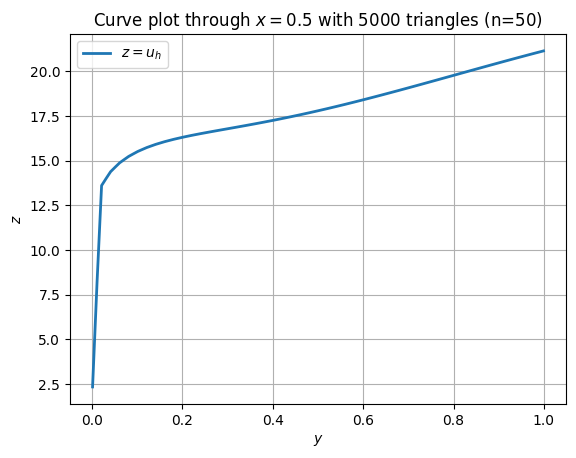

In [16]:
# Step 3: Plot
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(points_on_proc[:,1], u_values, linewidth=2, label="$z= u_h$")
ax1.set(xlabel = "$y$", ylabel = "$z$")
ax1.legend()
ax1.grid()
ax1.set_title(f"Curve plot through $x=0.5$ with {2*n**2} triangles (n={n})")

fig.savefig(f"n={n}.png")

print()

You can see below in Fig. 14 the change in the solution as mesh size increases. As you can see, there is a stark difference between the solutions when the mesh size is small. They vary from being wildly innacurate, so fairly close. Beyond $n=256$, results became difficult to distinguish from each other, so it is safe to assume this is the solution the method is converging on.

<table>
    <caption style="font-style:italic;text-align:center;caption-side: bottom;">Fig. 14 Different iterations of $u_h$ with increasing mesh sizes
    <tr>
        <td> 
            <img src="cross_sections/1n=8.png" alt="n=8"/>
            <img src="cross_sections/4n=64.png" alt="n=64"/> 
        </td>
        <td> 
            <img src="cross_sections/2n=16.png" alt="n=16"/>
            <img src="cross_sections/5n=128.png" alt="n=128"/> 
        </td>
        <td> 
            <img src="cross_sections/3n=32.png" alt="n=32"/> 
            <img src="cross_sections/6n=256.png" alt="n=256"/> 
        </td>
    </tr>
</table>

The choice of problem was not random, indeed it as contructed using the *method of manufactured solutions*, meaning there is an analytical $u$ that solves \[9\]. You can clearly see that substituting in $u_D = 20y^\frac12 + \frac12 x^2 + 2x$ for $u$ solves the equation on $\delta \Omega$, but the source term $f = 5y^{-\frac32} - 1$ was chosen specifically so that $-\nabla u_D = f$. So $u_D$ solves \[9\] on $\Omega$ as well. A plot of $u_D$ through the line $x=0.5$ is shown below, and as you can see, bares striking resemblance to our finite element approximations with larger mesh sizes. Some PDEs won't need so many finite elements to solve, and others will need more to provide an accurate soltuion, but it is surprising how bad the approximations are with smaller numbers of elements in this instance.

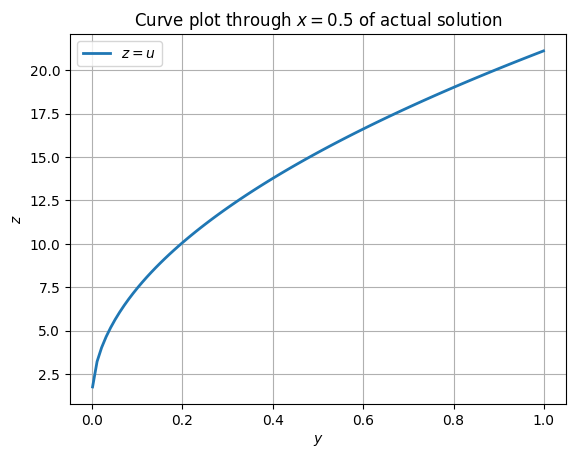

In [17]:
# Make data.
X = np.ones((1, 101))*0.5
Y = np.linspace(0 + tol, 1 - tol, 101)
Z = 20*Y**(1/2) + 0.5*X**2 + 2*X

# Plot
fig, ax1 = plt.subplots()
ax1.plot(Y, Z[0], linewidth=2, label="$z=u$")
ax1.set(xlabel = "$y$", ylabel = "$z$")
ax1.legend()
ax1.grid()
ax1.set_title("Curve plot through $x=0.5$ of actual solution")

print()

### 6.4 Steps to solving a PDE in FEniCSx

We have just worked through a full example of solving an instance of the Poisson Equation in FEniCSx. The steps we followed were:

- Create a mesh over your domain, either using Gmsh, or DOLFINx's own mesh class `dolfinx.mesh`.

- Define your chosen finite element space $V_h$

- Define our boundary condition(s) and (if necessary) interpolate these in our finite element space. Then apply the boundary conditions to the degrees of freedom on the boundary of our mesh by identifying the facets on the boundary by creating an instance of the `dolfinx.fem.dirichletbc` class. Other boundary conditions work similarly.

- Define the variational equation by first defining the test and trial functions, then the linear and bilinear terms, interpolating over $V_h$ where necessary.

- Create a `fem.petsc.LinearProblem` class and solve. Non-linear solvers are available for equations that cannot be broken into linear and bilinear form, but this is outside the scope of these notebooks.

- Visualise using a three-dimensional plotter like pythreejs or ipygany. If necessary, draw a contour plot by evalutating the solution along fixed lines of $x$, $y$ or $z$ values, using a bounding box tree.

##### Check Exercises 11

- Now it's your turn! Produce a finite element approximation for the following PDE:

$$
\begin{align}
-\nabla^2 u(x,y) &= 10\sin(x)\cos(y),\quad \text{in} \,\, \Omega \\
u(x,y) &= 5\sin x \cos y, \quad \text{on} \,\, \delta\Omega \\
\text{where } \Omega &= \left[0 , \pi\right] \times \left[ -\frac{\pi}{2} , \frac{\pi}{2} \right] \subset \mathbb{R}^2
\end{align}
$$

(Use the [dolfinx.mesh.create_rectangle](https://docs.fenicsproject.org/dolfinx/main/python/_modules/dolfinx/mesh.html#create_rectangle) function to define the mesh)

- Once you have your solution, visualise it with the three ways shown above.

## 7. A time dependent example

### 7.1 The Wave Equation

The wave equation is a time-dependent Partial Differential Equation describing the propogation of waves through a medium. It is  used to describe electromagentic waves, water waves, the vibration of a string, and many other physical phenomena. As such, it is important in many areas of physics to be able to solve the wave equation. While it is possible to solve certain instances of the wave equation analytically, we will use FEniCSx to obtian a numerical solution that can be applied to all instances of the equation. We begin by defining the equation itself, as well as a boundary condition and a initial conditions.


$$
\begin{align}
\frac{\partial^2 u}{\partial t^2} &= c^2 \nabla^2 u \,\, &\text{on} \,\, \Omega \\
u(x,y,t) &= 0 \,\, &\text{on} \,\, \Omega \\
u(x,y,0) &= e^{-\alpha(x^2 + y^2)} \\
\dot{u}(x,y,0) &= 0 \\
\end{align}
$$

In the equation, $u$ is the waves position, and is a function of $x$, $y$ and $t$. $c$ is the speed of the wave. Our domain $\Omega$ is the the square $[-1, 1] \times [-1, 1]$. We have chosen a homogeneous Dirichlet boundary condition because it provides for a more simple visualisation. The inital condition we have chosen is a 2-Dimensional Gaussian function centered at the origin with a height of $\alpha$. There is no great significance to this, merely that it provides an interesting solution at the end. You can also see on line 4 that we have a second intial condition this time specifiying that the derivative of the wave's position should be $0$ initially. This must be specified because we have a second order derivative with respect to time in the equation. An interpretation of this condition would be that this is the waves initial velocity.

We begin as we did in Section 5.1; by discretising time. Using the superscript notation and Newtonian "dot" notation for derivatives with respect to time, [10] becomes

$$
\ddot{u}^{n+1} = c^2 \nabla u^{n+1} \tag*{[11]}
$$

As before, we use a finite difference quotient to approximate the derivative. However, instead of having a single derivative, we have a second order one. We can derive it from the one used in 5.1, $\dot{u} ^ {n+1} \approx \frac{u^{n+1} - u^n}{\Delta t}$. We then find,

$$
\begin{align*} \\
\ddot{u} ^ {n+1} &\approx \frac{\dot{u}^{n+1} - \dot{u}^n}{\Delta t} \\
&\approx \frac{ \frac{u^{n+1}-u^n}{\Delta t} - \frac{u^n-u^{n-1}}{\Delta t} }{\Delta t}\\
&\approx \frac{u^{n+1} -2u^n + u^{n-1}}{(\Delta t)^2} \tag*{[12]}
\end{align*}
$$

Now we can substiute [12] into [11] to get a discretised version of the wave equation, with unknowns on the left and knowns on the right. We say that $u^n$ and $u^{n-1}$ are known at the point of calculating $u^{n+1}$, because they would have been calculated in previous time steps.

$$
\begin{align}
\frac{u^{n+1} -2u^n + u^{n-1}}{(\Delta t)^2} &= c^2 \nabla^2 u^{n+1} \\
u^{n+1} -2u^n + u^{n-1} &= (\Delta t)^2 c^2 \nabla^2 u^{n+1} \\
u^{n+1} - (\Delta t)^2 c^2 \nabla^2 u^{n+1} &= 2u^n - u^{n-1} \tag*{[13]}
\end{align}
$$

There is one caveat to mention here. When $n=0$, we encounter the term $u^{-1}$. This is clearly undefined, $t$ must be at least $0$, so this is outside of our temporal domain. This is where our inital condition comes in. We can approximate the condition $\dot{u}^0 = 0$ with a finite difference quotient as well, giving the following expression for $u^{-1}$

$$
\dot{u}^0 = 0 \implies \frac{u^0 - u^{-1}}{\Delta t} = 0 \implies u^{-1} = u^0
$$

Now we derive the variational formulation using Green's first identity again.

$$
\begin{align}
L(v) = \iint_\Omega v\left( 2u^n - u^{n-1} \right) \mathrm{d}S &= \iint_\Omega v\left( u^{n+1} - (\Delta t)^2 c^2 \nabla^2 u^{n+1} \right) \mathrm{d}S \\
&= \iint_\Omega vu^{n+1} \mathrm{d}S - (\Delta t)^2 c^2\iint_\Omega v\nabla^2 u^{n+1} \mathrm{d}S \\
&= \iint_\Omega vu^{n+1} \mathrm{d}S - (\Delta t)^2 c^2 \left( \iint_\Omega \nabla v \cdot \nabla u^{n+1} \mathrm{d}S - \oint_{\delta\Omega} v\nabla u^{n+1} \cdot \underline{\mathrm{d}S} \right) \\
&= \iint_\Omega vu^{n+1} \mathrm{d}S - (\Delta t)^2 c^2 \iint_\Omega \nabla v \cdot \nabla u^{n+1} \mathrm{d}S \\
&= \iint_\Omega \left( vu^{n+1} - (\Delta t)^2 c^2 \nabla v \cdot \nabla u^{n+1} \right) \mathrm{d}S = a(u^{n+1}, v) \quad \forall v \in V_h, \quad n=0,1,\cdots \tag*{[14]}\\
\end{align}
$$

This shows our LHS is our linear form $L(v)$ and our right hand side is our bilinear form $a(u,v)$.

### 7.2 Defining and Solving

Now the mathematics is out of the way, its time to solve the problem. We start by defining the parameters of the problem.

In [18]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import fem, mesh, io, plot, cpp

# Define parameters
t = 0 # Start time
T = 5 # Final time
num_steps = 100  
dt = T / num_steps # Time step size = 0.05
alpha=10
c=1

Next, we define our mesh and finite element space.

In [19]:
# Define mesh
nx, ny = 50, 50
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([-1, -1]), np.array([1, 1])], 
                               [nx, ny], mesh.CellType.triangle)
Vh = fem.FunctionSpace(domain, ("CG", 1))

Now we define our inital conditions. This is done by interpolating over our finite element space.

In [20]:
# Create initial conditions
def initial_condition(x):
    return np.exp(-alpha*(x[0]**2+x[1]**2))

u_nMinus1 = fem.Function(Vh)
u_nMinus1.name = "u_nMinus1"
u_nMinus1.interpolate(initial_condition)

u_n = fem.Function(Vh)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

Next we define our boundary condition in the same way as before.

In [21]:
# Create boundary condition
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(Vh, domain.topology.dim-1, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), boundary_dofs, Vh)

Next we define our solution variable. We interpolate it over the inital condition, since initially, this is what it should be.

In [22]:
# Define solution variable
uh = fem.Function(Vh)
uh.name = "uh"
uh.interpolate(initial_condition)

Now we can define the variational problem. We write the expression we derived in [14] in UFL.

In [23]:
import ufl
u, v = ufl.TrialFunction(Vh), ufl.TestFunction(Vh)
a = u * v * ufl.dx + (dt**2)*(c**2)*ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx 
L = (2*u_n - u_nMinus1) * v * ufl.dx

To solve we proceed slightly differently than before. Instead of solving just one problem, we have $n+1$ problems, each relying on the previous problems for input. We will need to iterate over the time domain, incrementing `dt` until we reach `T`. Then, one approach would be to define and solve a new `fem.petsc.LinearProblem()` in each iteration, using the $u^n$ and $u^{n-1}$ from the previous time steps in the linear and bilinear forms. However, this is inefficient. You can see from [14], that the bilinear form $a(u^{n+1},v)$ does not change with each time step. Therefore, when constructing the linear equation, the mass matrix $A$ will be the same for every equation $n=0,1,\cdots$. Instead of reassembling the whole system at each time step, we only need to reassemble the term that changes with time, which is dictated by the linear form. The linear form corresponds to the load vector, refer to section 3.4 for a refresher on how the linear and bilinear forms become the load vector and mass matrix. Therefore, it is most efficient to assemble $A$ at $t=0$ and continue to use it throughout.

<img src="finite_difference_method.png" alt="Finite Difference Method Illustrated" style="margin-left:auto;margin-right:auto;">
<figcaption style="font-style:italic;text-align:center;">Fig.15 - Illustration of the method used, called a finite difference method</figcaption>

To implement this, we do not use the `LinearProblem()` class. We instead define the bilinear and linear forms separately in a class called `fem.form()`. This will allow us to assemble the mass matrix and load vector independently of one another. We first assemble the mass matrix. Then, our first load vector.

In [31]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = fem.petsc.create_vector(linear_form)

The `fem.petsc.assemble_matrix()` and `fem.petsc.create_vector()` functions return PETSc matrices and vector respectively. Therefore, in order to actually solve the eqaution, we are going to have to use PETSc directly. We assign our matrix and set the solver to be LU Factorisation.

In [32]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

We now proceed with solving. We won't be storing the full solution as an array of degrees of freedom like earlier. There is no need, and for our purposes an animation will tell us more about the solution. Pyvista is very useful here, it has functionality that allows us to write directly to a gif. We convert our dolfinx mesh to a pyvista unstructured grid and create a new plotter. Then we tell the plotter to open a new gif file. The degrees of freedom of the initial condition are assigned to the grid. Finally, a few parameters are set for drawing a scalar bar, title and other rendering options, and a renderer is created.

In [34]:
import pyvista
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(Vh))

plotter = pyvista.Plotter()
plotter.open_gif("wave.gif")

grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=1)

sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False, 
                            scalar_bar_args=sargs,
                            clim=[0, max(uh.x.array)])

Now we solve. The algorithm works like this

1. First we reset the value of $b$. Then assemble the new load vector based on the linear form.

2. Then, we apply the boundary condition to the load vector. We didn't do this in the assemble stage because we prefer to use "lifting" to apply the boundary conditions, a technique that preserves the symmetry of the matrix $A$. How this works is beyond the scope of the tutorial, but the point is, $b$ is now fully set.

3. Solve using our predefined solver. One should note that the `.ghostUpdate()` and `.scatter_forward()` methods are related to peforming the computation in parallel and are necessary.

4. Next, the functions $u^n$ and $u^{n-1}$ are updated. This also means we do not have to redefine our linear form, we only need to reassemble the load vector in the next iteration.

5. We then update the plot with the solution at our current time step, writing 1 frame to the gif file.

6. The loop then repeats until all systems have been generated, solved and plotted.

In [35]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution for previous time steps (u_nMinus1 -> u_n,  u_n -> uh)
    u_nMinus1.x.array[:] = u_n.x.array
    u_n.x.array[:] = uh.x.array

    # Update plot
    warped = grid.warp_by_scalar("uh", factor=1)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()

The result of all this can be seen by opening the `wave.gif` file. Below I have compiled a few different solutions for different instances and listed the parameters below. As you can see, it works quite well and appears to mimic water or elastic. You should try experimenting yourself with different boundary conditions, inital conditions and parameters.

<table>
    <caption style="font-style:italic;text-align:center;caption-side: bottom;">Fig. 15 Different kinds of problems solved by varying spatiotemporal parameters
    <tr>
        <td> 
            <img src="waves/slo_mo_wave.gif" alt="Slo-Mo Wave">
            <figcaption style="font-style:italic;text-align:center;">$T=10$, $dt=0.2$, $c=0.1$, $\alpha=10$ (Slow speed)</figcaption>
        </td>
        <td> 
            <img src="waves/rlyfastwave.gif" alt="n=32"/> 
            <figcaption style="font-style:italic;text-align:center;">$T=2$, $dt=0.05$, $c=2$, $\alpha=10$ (Fast speed)</figcaption> 
        </td>
    </tr>
    <tr>
        <td> 
            <img src="waves/localised_wave.gif" alt="Localised Wave">
            <figcaption style="font-style:italic;text-align:center;">$T=1$, $dt=0.05$, $c=1$, $\alpha=50$ (Large $\alpha$)</figcaption>
        </td>
        <td> 
            <img src="waves/hugewave.gif" alt="n=16"/>
            <figcaption style="font-style:italic;text-align:center;">$T=2$, $dt=0.05$, $c=1$, $\alpha=0.1$ (Small $\alpha$)</figcaption> 
        </td>
    </tr>
</table>

##### Check Exercises 12

- Create a finite element approximation for an instance of the heat equation of your choosing. Use the variational form you derived at the end of 5.2 when defining the problem.